<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [4]</a>'.</span>

In [1]:
from eoxhub import check_compatibility
check_compatibility("user-2022.10-14", dependencies=["GEODB"])



---------

The following environment variables are available:

* `GEODB_AUTH_AUD`, `GEODB_AUTH_CLIENT_ID`, `GEODB_AUTH_DOMAIN`, `GEODB_API_SERVER_URL`, `GEODB_AUTH_CLIENT_SECRET`, `GEODB_API_SERVER_PORT`


### <b>Urban delineation<b>
This notebook implements a GHSL settlement model algorithm as defined by the stage I of the Degree of Urbanisation (European Commission & Statistical Office of the European Union, 2021) and recommended by the UN STAT COM.
Model uses the population and built-up surface grid - European Commission, Joint Research Centre (JRC)<br> 
The method here implemented is described in detail bellow.

####  <b> GHSL - settlement model <b>
Delineate and classify settlement by typologies

#### Setlment L1 nomenclature:
##### Urban Centre - High Density Cluster (HDC)
##### Urban Cluster - Moderate Density Cluster (MDC) 

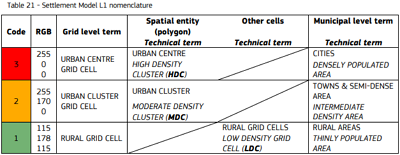

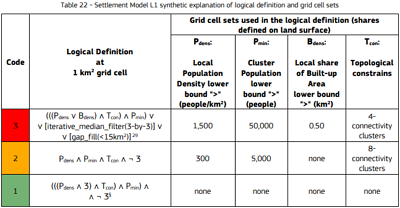
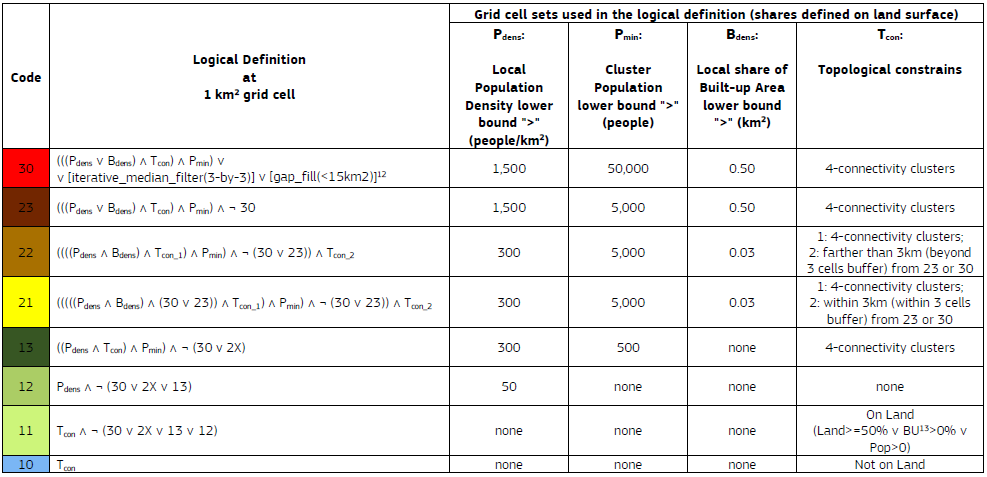

#### Setlment L2 nomenclature:
##### Urban Centre - High Density Cluster (HDC)
##### Dense Urban Cluster (DUC)
##### SemiDense Urban Cluster (SDUC)
##### Peri-Urban Cluster (PUC)

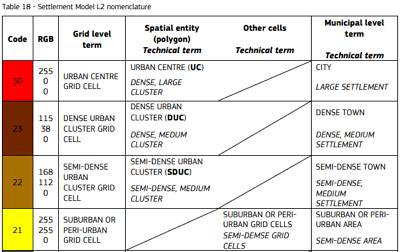
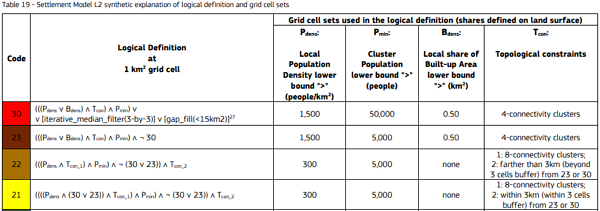

**GHSL data packages for settlement model:**<br>
<br>
built-up:
https://ghsl.jrc.ec.europa.eu/download.php?ds=bu
<br>
population:
https://ghsl.jrc.ec.europa.eu/download.php?ds=pop
<br>
<br>
Reference years: from 1975 to 2020, 5 years interval<br>
Resolution: 1km<br>
Coord. system: Mollweide<br>
Complete information about GHSL open data are available at:<br>
https://ghsl.jrc.ec.europa.eu/documents/GHSL_Data_Package_2022.pdf?t=1655995832
<br>
<br>

#### <b>Parameters by definition of GHSL settlement model L1 and L2<b>

<ul>   
<li>Threshold for total population per square kilometer : HDC_Pdens / MDC_Pdens </li>
<li>Threshold for population per cluster : HDC_Pmin / MDC_Pmin </li>  
<li>Threshold for % of built-up area : HDC_Bdens </li>
<li>Cluster connectivity : HDC_Tcon / MDC_Tcon </li>    
</ul>

##### <b>Constants : Pdens, Bdens, Pmin, Tcon<b>

In [2]:
# local population density (HDC: 1500 people/km2, MDC: 300 people/km2)
HDC_Pdens=1500
MDC_Pdens =300

# built-up area share > then
HDC_Bdens=500000 # (share of built-up area/km2: 0.5 => 500000 m2/km2)

# cluster populatin > then   (HDC: 50000 people, MDC: 5000 people)
HDC_Pmin=50000
MDC_Pmin=5000

# connectivity clusters
# Tcon=1 for 4-connectivity clusters, Tcon=2 for 8-connectivity clusters
HDC_Tcon=1 
MDC_Tcon=2 

# gap filling (<15km2)
HDC_GAPfill=15

#### <b>Load libraries:<b>

In [3]:
from xcube.core.store import new_data_store

import os
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, box

import xarray as xr
import rioxarray as rxr

import rasterio
import rasterio.features
from rasterio.features import shapes

from skimage import measure, morphology
from skimage.morphology import square
import scipy

import ipywidgets as widgets
import matplotlib.pyplot as plt

import folium
from folium import plugins


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [4]:
import time
import datetime
#!pip install ipython-autotime
%load_ext autotime
%time 
start_time = datetime.datetime.now().time().strftime('%H:%M:%S')

ModuleNotFoundError: No module named 'autotime'

### <b>Select reference year and area of interest: <b>
  Before starts, the reference year and the area of interest needs to be defined.
#### <b>Reference year <b>  

In [ ]:
# Select reference year:
# from 1975 to 2020, 5 years interval:
# valid values are: 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020

REFyear=2020


#### <b>Area of interest <b>

In [ ]:
# Select AOI by lat/lon coordinates -  example for area of Poland, Czechia and Slovakia:
x1 = 10  # degree (E-W)
y1 = 47 # degree (N-S)
x2 = 25  # degree (E-W)
y2 = 55 # degree (N-S)

aoi_centre = [(y2+y1)/2,(x2+x1)/2]
print(aoi_centre)

bbox = x1, y1, x2, y2
print(bbox)

In [ ]:
geom = box(*bbox)
AOI = gpd.GeoDataFrame({"id":1,"geometry":[geom]})
AOI.set_crs(epsg=4326, inplace=True)  # WGS84
AOI54009 = AOI.to_crs(crs='ESRI:54009')

In [ ]:
from branca.element import Figure
fig = Figure(width=600, height=600)

m = folium.Map(aoi_centre, zoom_start=5, tiles='cartodbpositron')  # ,width=500, height=500
lat_interval = 1
lon_interval = 1

# parallels:
for lat in range(-90, 91, lat_interval):
     folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(m)
# meridianss:
for lon in range(-180, 181, lon_interval):
    folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(m)

AOI54009.explore(m=m,style_kwds=dict(color='blue',fillColor='None', opacity=0.7))
fig.add_child(m)
m

### <b>Input data<b>

#### Open GHS built-up surface

In [ ]:
BTU_data_store = new_data_store("s3", root="xcube-dcfs/GHSL/GHS-BUILT-S/",
                            storage_options=dict(anon=True) # anon=True - anonymous access (default False)
                           )

In [ ]:
BTU_data_store_info = list(BTU_data_store.get_data_ids())
BTU_data_store_info

In [ ]:
# Select built-up data for Reference year
BTU_REFyear= '\n'.join(s for s in BTU_data_store_info if str(REFyear) in s)
# BTU_REFyear

In [ ]:
# Info about built-up data for Reference year
BTU_data_store.describe_data(BTU_REFyear).to_dict()

In [ ]:
# # Info about population data for Reference year
# print(BTU_data_store.open_data(BTU_REFyear).num_levels, '\n')
# print(BTU_data_store.open_data(BTU_REFyear).datasets, '\n')
# BTU_data_store.open_data(BTU_REFyear).grid_mapping

In [ ]:
level = 0   # this is the highest resolution, which corresponds to 1km

# Build-up dataset for selected Reference year - clipped by AOI
BTU_ds_0 = BTU_data_store.open_data(BTU_REFyear).get_dataset(level).rio.clip(AOI54009.geometry, AOI54009.crs)
BTU_ds_0 = BTU_ds_0.rename({"band_1": "built-up"})
#BTU_ds_0

In [ ]:
# # Info AOI coordinates in the world projection Mollweide (ESRI:54009)
# print(BTU_ds_0.x.min().values, BTU_ds_0.x.max().values)
# print(BTU_ds_0.y.min().values, BTU_ds_0.y.max().values)

#### Open GHS population grid 

In [ ]:
POP_data_store = new_data_store("s3", 
                            root="xcube-dcfs/GHSL/GHS-POP/",
                            storage_options=dict(anon=True)
                           )

OP_data_store info:

In [ ]:
POP_data_store_info=list(POP_data_store.get_data_ids())
POP_data_store_info

In [ ]:
# Select population data for Reference year
POP_REFyear= '\n'.join(s for s in POP_data_store_info if str(REFyear) in s)
#POP_REFyear

In [ ]:
# Info about built-up data for Reference year
POP_data_store.describe_data(POP_REFyear).to_dict()

In [ ]:
# # Info about population data for Reference year
# print(POP_data_store.open_data(POP_REFyear).num_levels, '\n')
# print(POP_data_store.open_data(POP_REFyear).datasets, '\n')
# POP_data_store.open_data(POP_REFyear).grid_mapping

In [ ]:
level = 0   # this is the highest resolution, which corresponds to 1km

# Population dataset  for selected Reference year - clipped by AOI
POP_ds_0 = POP_data_store.open_data(POP_REFyear).get_dataset(level).rio.clip(AOI54009.geometry, AOI54009.crs)
POP_ds_0 = POP_ds_0.rename({"band_1": "population_grid"})
#POP_ds_0

#### Dataset to DataArray

In [ ]:
BTU_da=(BTU_ds_0['built-up']).squeeze()
BTU_da = BTU_da.load()
BTU_da=BTU_da.where(BTU_da != BTU_da.attrs['_FillValue']).fillna(0)
BTU_da

In [ ]:
POP_da=(POP_ds_0['population_grid']).squeeze()
POP_da = POP_da.load()
POP_da=POP_da.where(POP_da != POP_da.attrs['_FillValue']).fillna(0)
POP_da

In [ ]:
# # Info about  DataArray
# print(type(POP_da),'\n')
# print(type(POP_da.data))
# print(POP_da.name), print()
# print("The shape of data is:\n", POP_da.shape,'\n')
# print(POP_da.coords), print()
# print("the minimum raster value is:\n", np.nanmin(POP_da.values))
# print("the maximum raster value is:\n", np.nanmax(POP_da.values),'\n')
# print('dim:',POP_da.dims,'\n')
# print('attributes/metadata:\n',POP_da.attrs,'\n')
# print('----------------')
# # View generate metadata associated with the raster file
# # World Mollweide  ESRI:54009, 
# print("The crs of data is:\n", POP_da.rio.crs,'\n')
# print('transform:\n',POP_da.rio.transform(),'\n')
# print("The spatial extent is:\n", POP_da.rio.bounds(),'\n')
# print("The nodatavalue of data is:\n", POP_da.rio.nodata,'\n')
# print("The spatial resolution of data is:\n", POP_da.rio.resolution(),'\n')

# print(BTU_da.data.min(), BTU_da.data.max())
# print(POP_da.data.min(), POP_da.data.max().round(0))
# POP_da.data

###  <b>L1: Urban Centre (HDC) and Urban Cluster (MDC)<b>

#### step1: built-up and population data - binary masks  by model definition

In [ ]:
# HDC
# built-up area
HDC_BTU_mask = 1 * np.ones_like(BTU_da) * (BTU_da > HDC_Bdens).astype(np.int8)  # HDC_Bdens (share of built-up area/km2: 0.5 => 500000 m2/km2)
# population
HDC_POP_mask = 1 * np.ones_like(POP_da) * (POP_da > HDC_Pdens).astype(np.int8) # HDC_Pdens >=1500 inh/km2
HDC_UC01_mask = HDC_BTU_mask + HDC_POP_mask

# MDC
MDC_POP_mask = 1 * np.ones_like(POP_da) * (POP_da > MDC_Pdens).astype(np.int8) # MDC_Pdens >=300  inh/km2

In [ ]:
# BINARY MASK:
HDC_UC01_mask = 1 * np.ones_like(HDC_UC01_mask) * (HDC_UC01_mask> 0).astype(np.int8)
MDC_UC01_mask = MDC_POP_mask

#### step2: cluster connectivity
https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label

In [ ]:
# 4/8-connectivity regions:
# HDC_Tcon=1 for 4-connectivity clusters
# MDC_Tcon=2 for 8-connectivity clusters

HDC_UC02_4conn = measure.label(HDC_UC01_mask, background=0, return_num=False, connectivity=HDC_Tcon)
# print('HDC number of regions:', HDC_UC02_4conn.max())

MDC_UC02_8conn = measure.label(MDC_UC01_mask, background=0, return_num=False, connectivity=MDC_Tcon)
# print('MDC number of regions:', MDC_UC02_8conn.max())

#### step3: total population in cluster

In [ ]:
HDC_UC03=np.zeros_like(HDC_POP_mask).astype('int')

POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, HDC_UC02_4conn.max()):
    POPregionID=((HDC_UC02_4conn == regionID).astype('int')) * POP_da.data    
    # threshold for population in cluster > 50000
    if POPregionID.sum() > HDC_Pmin:
        POPregionSUM.append(int(round(POPregionID.sum())))
        POPregionIDsum.append(regionID)
        HDC_UC03=HDC_UC03+np.where(HDC_UC02_4conn == regionID, HDC_UC02_4conn, 0)

In [ ]:
MDC_UC03=np.zeros_like(MDC_POP_mask).astype('int')

POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, MDC_UC02_8conn.max()):
    POPregionID=((MDC_UC02_8conn == regionID).astype('int')) * POP_da.data    
    # threshold for population in cluster > 5000
    if POPregionID.sum() > MDC_Pmin:
        POPregionSUM.append(int(round(POPregionID.sum())))
        POPregionIDsum.append(regionID)
        MDC_UC03=MDC_UC03+np.where(MDC_UC02_8conn == regionID, MDC_UC02_8conn, 0)

### L1: Urban Center (HDC)

#### step4: Urban Centre (HDC) - gaps filling < 15km2

inverse raster / gaps

In [ ]:
HDC_UC03_BIN=np.where(HDC_UC03 > 0, 1, 0)
HDC_UC03_INV=np.where(HDC_UC03_BIN == 1, 0, 1)

HDC_UC03_INV = measure.label(HDC_UC03_INV, background=0, connectivity=2) # 8-connectivity
# number of holes
# HDC_UC03_INV.max()

gaps filling

In [ ]:
unique, counts = np.unique(HDC_UC03_INV, return_counts=True,)
gaps=list(zip(unique, counts)) 
#print(gaps)

for gap in gaps:
    if gap[1] < HDC_GAPfill:
        gapID=(HDC_UC03_INV == gap[0]).astype(int)        
        HDC_UC03_BIN=HDC_UC03_BIN+gapID

regions where POP > 50000 with filled gaps < 15km2 

In [ ]:
HDC_UC03_4conn = measure.label(HDC_UC03_BIN, background=0, connectivity=HDC_Tcon)  # connectivity=HDC_Tcon
print(HDC_UC03_4conn.min(),HDC_UC03_4conn.max())

In [ ]:
# binary raster
HDC_UC04_BIN=np.where(HDC_UC03_4conn >= 1, 1, 0)
print(HDC_UC04_BIN.sum())

#### step5: Urban Centre (HDC) - morphology

closing, erosion, dilatation

In [ ]:
HDC_UC04=np.zeros_like(HDC_UC03_BIN).astype('int')
# regiony sa vyhodnocuju sekvencne v cykle:
POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, HDC_UC03_4conn.max()):
    # mask 0-1 for region, # POP in region
    POPregionID=((HDC_UC03_4conn == regionID).astype('int'))  
    #print(POPregionID.min(), POPregionID.max(), POPregionID.sum())
    POPregionID = morphology.binary_closing(POPregionID, square(3))
    POPregionID= morphology.binary_dilation(POPregionID)
    POPregionID= morphology.binary_erosion(POPregionID)
    #POPregionID = skimage.morphology.binary_closing(POPregionID, square(3))
    HDC_UC04=HDC_UC04+POPregionID
    #print(HDC_UC05.sum())

In [ ]:
# gaps filling after morphology:
HDC_UC04_INV=np.where(HDC_UC04 == 1, 0, 1)
HDC_UC04_INV = measure.label(HDC_UC04_INV, background=0, connectivity=2)
# number of holes
HDC_UC04_INV.max()

In [ ]:
unique1, counts1 = np.unique(HDC_UC04_INV, return_counts=True,)
gaps1 = [x for x in zip(unique1, counts1) if x[1] < HDC_GAPfill]
#print(gaps1)

for gap1 in gaps1:
    gapID1=(HDC_UC04_INV == gap1[0]).astype(int)
    HDC_UC04=HDC_UC04+gapID1

In [ ]:
HDC_UC04_4conn = measure.label(HDC_UC04, background=0, connectivity=HDC_Tcon)
HDC_UC04_4conn.max()

In [ ]:
# binary raster
HDC_UC04_4conn_BIN=np.where(HDC_UC04_4conn >= 1, 1, 0)
HDC_UC04_4conn_BIN.sum()

### L1: Urban Cluster (MDC)

In [ ]:
# binary
MDC_UC03=np.where(MDC_UC03 > 0, 1, 0)
# 
MDC_UC04=MDC_UC03-HDC_UC04
MDC_UC04=np.where(MDC_UC04 == 1, 1, 0)

In [ ]:
MDC_UC04_8conn = measure.label(MDC_UC04, background=0, connectivity=MDC_Tcon)
print(MDC_UC04_8conn.min(),MDC_UC04_8conn.max())

\
HDC and MDC to vector

HDC:  numpy.ndarray to DataArray

In [ ]:
HDC_UC05 = xr.DataArray(
    data=HDC_UC04_4conn,
    dims=BTU_da.dims,
    coords=BTU_da.coords,
    name='urban_centre',
    )

HDC_UC05=HDC_UC05.astype(np.int16)
HDC_UC05

In [ ]:
# # Info about HDC DataArray
# print('type:',type(HDC_UC05))
# print('name:',HDC_UC05.name)
# print('shape:',HDC_UC05.shape)
# #print(HDC_UC05.coords)
# print('dim:',HDC_UC05.dims,'\n')
# # World Mollweide  ESRI:54009
# print("The crs is: ", HDC_UC05.rio.crs)
# print('transform: ',HDC_UC05.rio.transform())
# print("The spatial extent is: ", HDC_UC05.rio.bounds())
# print("The nodatavalue of data is: ", HDC_UC05.rio.nodata)
# print("The shape of data is: ", HDC_UC05.shape)
# print("The spatial resolution of data is: ", HDC_UC05.rio.resolution())
# print("the minimum raster value is: ", np.nanmin(HDC_UC05.values))
# print("the maximum raster value is: ", np.nanmax(HDC_UC05.values))
# print("The metadata of data is: ", HDC_UC05.attrs)

HDC: export to vector

In [ ]:
# mask=None
mask=HDC_UC05.data != 0
with HDC_UC05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=4, transform=HDC_UC05.rio.transform())))

geoms = list(results)
# first feature
# print(geoms[0])

In [ ]:
HDC_UrbanCentre  = gpd.GeoDataFrame.from_features(geoms)
HDC_UrbanCentre.crs=HDC_UC05.rio.crs
HDC_UrbanCentre.raster_val=HDC_UrbanCentre.raster_val.astype('int')
HDC_UrbanCentre.rename(columns={'raster_val':'hdcid'}, inplace=True)
HDC_UrbanCentre['area_km2'] = HDC_UrbanCentre['geometry'].area/ 10**6
HDC_UrbanCentre['code']=3
HDC_UrbanCentre.sort_values(['area_km2'],ascending=False).head(3)

MDC:  numpy.ndarray to DataArray

In [ ]:
MDC_UC05 = xr.DataArray(
    data=MDC_UC04_8conn,
    dims=BTU_da.dims,
    coords=BTU_da.coords,
    name='urban_cluster',
    )

MDC_UC05=MDC_UC05.astype(np.int16)
MDC_UC05

In [ ]:
# # BASIC INFO
# print('type:',type(MDC_UC05))
# print('name:',MDC_UC05.name)
# print('shape:',MDC_UC05.shape)
# #print(MDC_UC05.coords)
# print('dim:',MDC_UC05.dims,'\n')
# # View generate metadata associated with the raster file
# # World Mollweide  ESRI:54009
# print("The crs is: ", MDC_UC05.rio.crs)
# print('transform: ',MDC_UC05.rio.transform())
# print("The spatial extent is: ", MDC_UC05.rio.bounds())
# print("The nodatavalue of data is: ", MDC_UC05.rio.nodata)
# print("The shape of data is: ", MDC_UC05.shape)
# print("The spatial resolution of data is: ", MDC_UC05.rio.resolution())
# print("the minimum raster value is: ", np.nanmin(MDC_UC05.values))
# print("the maximum raster value is: ", np.nanmax(MDC_UC05.values))
# print("The metadata of data is: ", MDC_UC05.attrs,'\n')
# print(MDC_UC05.data.max())

MDC: export to vector

In [ ]:
# mask=None
mask=MDC_UC05.data != 0
with MDC_UC05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=8, transform=MDC_UC05.rio.transform())))

geoms = list(results)

In [ ]:
MDC_UrbanCluster  = gpd.GeoDataFrame.from_features(geoms)
MDC_UrbanCluster.crs=MDC_UC05.rio.crs
MDC_UrbanCluster.raster_val=MDC_UrbanCluster.raster_val.astype('int')
MDC_UrbanCluster.rename(columns={'raster_val':'mdcid'}, inplace=True)
MDC_UrbanCluster["area_km2"] = MDC_UrbanCluster['geometry'].area/ 10**6
MDC_UrbanCluster['code']=2
MDC_UrbanCluster.sort_values(['area_km2'],ascending=False).head(3)

### HDC and MDC export to shapefiles

In [ ]:
# Create folder for GHSL_results, if it doesn't exist:
Path(os.path.realpath('GHSL_results')).mkdir(parents=True, exist_ok=True) 

In [ ]:
# EXPORT 2 shapefile World Mollweide (ESRI:54009)
HDC_UrbanCentre.to_file(os.path.join(os.path.realpath('GHSL_results'),'HDC_UrbanCentre_'+str(REFyear)+'.shp'))
# Export to shapefile WGS84 (EPSG:4326 )
# HDC_UrbanCentre.to_crs(epsg=4326).to_file(os.path.join(os.path.realpath('GHSL_results'),'HDC_UrbanCentre_4326_'+str(REFyear)+'.shp'))

# EXPORT 2 shapefile World Mollweide (ESRI:54009)
MDC_UrbanCluster.to_file(os.path.join(os.path.realpath('GHSL_results'),'MDC_UrbanCluster_'+str(REFyear)+'.shp'))
# Export to shapefile WGS84 (EPSG:4326 )
# MDC_UrbanCentre.to_crs(epsg=4326).to_file(os.path.join(os.path.realpath('GHSL_results'),'MDC_UrbanCluster_4326_'+str(REFyear)+'.shp'))

### L1: Visualization of results

In [ ]:
fig = Figure(width=600, height=600)

m = AOI54009.explore(style_kwds={'fillColor':'None','color':'blue','weight': 1}, name='aoi')

# parallels:
for lat in range(-90, 91, lat_interval):
     folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(m)
# meridianss:
for lon in range(-180, 181, lon_interval):
    folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(m)

MDC_UrbanCluster.explore(m=m,style_kwds={'fillColor':'orange','color':'orange','weight': 1}, name='MDC_UrbanCluster')
HDC_UrbanCentre.explore(m=m,style_kwds={'fillColor':'red','color':'red','weight': 1.5}, name='HDC_UrbanCentre')

folium.LayerControl('topright',collapsed=True).add_to(m)
minimap = plugins.MiniMap(height=90, width=90, zoom_level_offset=-7)
m.add_child(minimap)

fig.add_child(m)
m

### <b>L2: Dense Urban Cluster (DUC), Semi-Dense Urban Cluster (SDUC) and  Peri-Urban Cluster (PUC)<b>

### step1: Dense Urban Cluster (DUC)

In [ ]:
# MASK
DUC_mask=HDC_UC01_mask  
#print(DUC_mask.sum())

In [ ]:
# CONNECTIVITY
DUC_4conn = measure.label(DUC_mask, background=0, return_num=False, connectivity=HDC_Tcon) #.squeeze()
print('DUC number of regions:', DUC_4conn.max())

In [ ]:
# TOTAL POPULATION IN CLUSTER
DUC_UC03=np.zeros_like(HDC_POP_mask).astype('int')

POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, DUC_4conn.max()):
    POPregionID=((DUC_4conn == regionID).astype('int')) * POP_da.data    
    # threshold for population in cluster > 5000
    if POPregionID.sum() > MDC_Pmin:
        POPregionSUM.append(int(round(POPregionID.sum())))
        POPregionIDsum.append(regionID)
        DUC_UC03=DUC_UC03+np.where(DUC_4conn == regionID, DUC_4conn, 0)

In [ ]:
# SUBTRACTION OF HDC
DUC_UC03_BIN=np.where(DUC_UC03 > 0, 1, 0)
DUC_UC03_BIN=DUC_UC03_BIN-HDC_UC04_4conn_BIN
DUC_UC03_BIN=np.where(DUC_UC03_BIN >0, 1, 0)
print(DUC_UC03_BIN.sum())

In [ ]:
# CONNECTIVITY
DUC_UC04_4conn = measure.label(DUC_UC03_BIN, background=0, connectivity=HDC_Tcon)  # connectivity=HDC_Tcon
print(DUC_UC04_4conn.min(),DUC_UC04_4conn.max())

In [ ]:
# BINARY MASK
DUC_UC04_4conn_BIN=np.where(DUC_UC04_4conn > 0, 1, 0)
DUC_UC04_4conn_BIN.sum()

DUC:  numpy.ndarray to DataArray

In [ ]:
DUC_UC05 = xr.DataArray(
    data=DUC_UC04_4conn,
    dims=BTU_da.dims,
    coords=BTU_da.coords,
    name='dense_urban_cluster',
    )

DUC_UC05=DUC_UC05.astype(np.int16)
DUC_UC05

DUC: export to vector

In [ ]:
# mask=None
mask=DUC_UC05.data != 0
with DUC_UC05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=4, transform=DUC_UC05.rio.transform())))

geoms = list(results)

In [ ]:
DUC_DenseUrbanCluster  = gpd.GeoDataFrame.from_features(geoms)
DUC_DenseUrbanCluster.crs=DUC_UC05.rio.crs
DUC_DenseUrbanCluster.raster_val=DUC_DenseUrbanCluster.raster_val.astype('int')
DUC_DenseUrbanCluster.rename(columns={'raster_val':'ducid'}, inplace=True)
DUC_DenseUrbanCluster['code']=23

### step2: Semi-Dense Urban Cluster (SDUC)

In [ ]:
# MASK
SDUC_mask=MDC_UC01_mask 
print(DUC_mask.sum())

In [ ]:
# CONNECTIVITY
SDUC_8conn = measure.label(SDUC_mask, background=0, return_num=False, connectivity=MDC_Tcon) # 8-connectivity cluster
print('SDUC number of regions:', SDUC_8conn.max())

In [ ]:
# TOTAL POPULATION IN CLUSTER
SDUC_UC03=np.zeros_like(HDC_POP_mask).astype('int')

POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, SDUC_8conn.max()):
    POPregionID=((SDUC_8conn == regionID).astype('int')) * POP_da.data    
    # threshold for population in cluster > 5000
    if POPregionID.sum() > MDC_Pmin:
        POPregionSUM.append(int(round(POPregionID.sum())))
        POPregionIDsum.append(regionID)
        SDUC_UC03=SDUC_UC03+np.where(SDUC_8conn == regionID, SDUC_8conn, 0)

In [ ]:
# BEYOND 3 CELLS BUFFER
SDUC_UC03_BIN=np.where(SDUC_UC03 > 0, 1, 0)
SDUC_UC03_BIN=SDUC_UC03_BIN - (scipy.ndimage.binary_dilation(HDC_UC04_4conn_BIN, iterations=3).astype(HDC_UC04_4conn_BIN.dtype)) - (scipy.ndimage.binary_dilation(DUC_UC04_4conn_BIN, iterations=3).astype(DUC_UC04_4conn_BIN.dtype))
SDUC_UC03_BIN=np.where(SDUC_UC03_BIN >0, 1, 0)
print(SDUC_UC03_BIN.sum())

In [ ]:
SDUC_UC04_8conn = measure.label(SDUC_UC03_BIN, background=0, connectivity=MDC_Tcon)  # connectivity=HDC_Tcon
print(SDUC_UC04_8conn.min(),SDUC_UC04_8conn.max())

In [ ]:
SDUC_UC04_8conn_BIN=np.where(SDUC_UC04_8conn > 0, 1, 0)
SDUC_UC04_8conn_BIN.sum()

SDUC:  numpy.ndarray to DataArray

In [ ]:
SDUC_UC05 = xr.DataArray(
    data=SDUC_UC04_8conn,
    dims=BTU_da.dims,
    coords=BTU_da.coords,
    name='semidense_urban_cluster',
    )

SDUC_UC05=SDUC_UC05.astype(np.int16)
SDUC_UC05

SDUC: export to vector

In [ ]:
# mask=None
mask=SDUC_UC05.data != 0
with SDUC_UC05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=4, transform=SDUC_UC05.rio.transform())))

geoms = list(results)
# first feature
# print(geoms[0])

In [ ]:
SDUC_SemiDenseUrbanCluster  = gpd.GeoDataFrame.from_features(geoms)
SDUC_SemiDenseUrbanCluster.crs=SDUC_UC05.rio.crs
SDUC_SemiDenseUrbanCluster.raster_val=SDUC_SemiDenseUrbanCluster.raster_val.astype('int')
SDUC_SemiDenseUrbanCluster.rename(columns={'raster_val':'sducid'}, inplace=True)
SDUC_SemiDenseUrbanCluster['code']=22

### step3: Peri-Urban Cluster (PUC)

In [ ]:
# MASK
PUC_UC03_BIN=np.where(SDUC_UC03 > 0, 1, 0)

In [ ]:
# INSIDE 3 CELLS BUFFER
UC_DUC = HDC_UC04_4conn_BIN + DUC_UC04_4conn_BIN
UC_DUC_BIN = np.where(UC_DUC >=1, 1, 0)
print(UC_DUC_BIN.sum())

UC_DUC_BD3=(scipy.ndimage.binary_dilation(UC_DUC_BIN, iterations=3).astype(UC_DUC_BIN.dtype))-UC_DUC_BIN
print(UC_DUC_BD3.min(), UC_DUC_BD3.max())
UC_DUC_BD3_BIN = np.where(UC_DUC_BD3 >=1, 1, 0)
print(UC_DUC_BD3_BIN.sum())

In [ ]:
PUC_UC03_PERI=PUC_UC03_BIN+UC_DUC_BD3_BIN
print(PUC_UC03_PERI.min(), PUC_UC03_PERI.max())
PUC_UC03_PERI_BIN = np.where(PUC_UC03_PERI >=2, 1, 0)
print(PUC_UC03_PERI_BIN.sum())

In [ ]:
# CONNECTIVITY
PUC_UC04_8conn = measure.label(PUC_UC03_PERI_BIN, background=0, connectivity=MDC_Tcon)  # connectivity=HDC_Tcon
print(PUC_UC04_8conn.min(),PUC_UC04_8conn.max())

In [ ]:
PUC_UC04_8conn_BIN=np.where(PUC_UC04_8conn > 0, 1, 0)
PUC_UC04_8conn_BIN.sum()

PUC: numpy.ndarray to DataArray

In [ ]:
PUC_UC05 = xr.DataArray(
    data=PUC_UC04_8conn,
    dims=BTU_da.dims,
    coords=BTU_da.coords,
    name='peri_urban_cluster',
    )

PUC_UC05=PUC_UC05.astype(np.int16)
PUC_UC05

PUC: export to vector

In [ ]:
# mask=None
mask=PUC_UC05.data != 0
with PUC_UC05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=4, transform=PUC_UC05.rio.transform())))

geoms = list(results)
# first feature
# print(geoms[0])

In [ ]:
PUC_PeriUrbanCluster  = gpd.GeoDataFrame.from_features(geoms)
PUC_PeriUrbanCluster.crs=PUC_UC05.rio.crs
PUC_PeriUrbanCluster.raster_val=PUC_PeriUrbanCluster.raster_val.astype('int')
PUC_PeriUrbanCluster.rename(columns={'raster_val':'periurid'}, inplace=True)
PUC_PeriUrbanCluster['code']=21

### DUC, SDUC and PUC export to shapefile

DUC: export to shapefile

In [ ]:
# EXPORT 2 shapefile World Mollweide (ESRI:54009)
DUC_DenseUrbanCluster.to_file(os.path.join(os.path.realpath('GHSL_results'),'DUC_DenseUrbanCluster_'+str(REFyear)+'.shp'))

# Export to shapefile WGS84 (EPSG:4326 )
# DUC_DenseUrbanCluster.to_crs(epsg=4326).to_file(os.path.join(os.path.realpath('GHSL_results'),'DUC_DenseUrbanCluster_4326_'+str(REFyear)+'.shp'))

SDUC: export to shapefile

In [ ]:
# EXPORT 2 shapefile World Mollweide (ESRI:54009)
SDUC_SemiDenseUrbanCluster.to_file(os.path.join(os.path.realpath('GHSL_results'),'SDUC_SemiDenseUrbanCluster_'+str(REFyear)+'.shp'))

# Export to shapefile WGS84 (EPSG:4326 )
# SDUC_SemiDenseUrbanCluster.to_crs(epsg=4326).to_file(os.path.join(os.path.realpath('GHSL_results'),'SDUC_SemiDenseUrbanCluster_4326_'+str(REFyear)+'.shp'))

PUC: export to shapefile

In [ ]:
# EXPORT 2 shapefile World Mollweide (ESRI:54009)
PUC_PeriUrbanCluster.to_file(os.path.join(os.path.realpath('GHSL_results'),'PUC_PeriUrbanCluster_'+str(REFyear)+'.shp'))

# Export to shapefile WGS84 (EPSG:4326 )
# PUC_PeriUrbanCluster.to_crs(epsg=4326).to_file(os.path.join(os.path.realpath('GHSL_results'),'PUC_PeriUrbanCluster_4326'+str(REFyear)+'.shp'))

In [ ]:
end_time = datetime.datetime.now().time().strftime('%H:%M:%S')
total_time=(datetime.datetime.strptime(end_time,'%H:%M:%S') - datetime.datetime.strptime(start_time,'%H:%M:%S'))
print(total_time)

### L2: Visualization of results

In [ ]:
fig = Figure(width=600, height=600)

m = AOI54009.explore(style_kwds={'fillColor':'None','color':'blue','weight': 1}, name='aoi')

# parallels:
for lat in range(-90, 91, lat_interval):
     folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(m)
# meridianss:
for lon in range(-180, 181, lon_interval):
    folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(m)

PUC_PeriUrbanCluster.explore(m=m,style_kwds={'fillColor':'yellow','color':'yellow','weight': 1.5}, name='PUC_PeriUrbanCluster')
SDUC_SemiDenseUrbanCluster.explore(m=m,style_kwds={'fillColor':'darkgoldenrod','color':'darkgoldenrod','weight': 1.5}, name='SDUC_SemiDenseUrbanCluster')
DUC_DenseUrbanCluster.explore(m=m,style_kwds={'fillColor':'brown','color':'brown','weight': 1.5}, name='DUC_DenseUrbanCluster')

MDC_UrbanCluster.explore(m=m,style_kwds={'fillColor':'orange','color':'orange','weight': 1}, name='MDC_UrbanCluster', show = False)
HDC_UrbanCentre.explore(m=m,style_kwds={'fillColor':'red','color':'red','weight': 1.5}, name='HDC_UrbanCentre')

folium.LayerControl('topright',collapsed=True).add_to(m)
minimap = plugins.MiniMap(height=90, width=90, zoom_level_offset=-7)
m.add_child(minimap)

fig.add_child(m)
m